# K-armed Bandit problem
- There are several options that you can choose repeatedly, or there are multiple actions that you can choose one to take.
- After you make a choise, you receive a numerical reward that follows a probability distribution that depends on the action taken.
- You want to maximize the expecyed total reward over a time period, for example 100 action selections (time steps).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import *

In [5]:
def argmaxBTR(arr: np.ndarray, axis: int = None):
    """Argmax but break ties randomly

    :param arr: numpy array
    :param axis: axis of argmax
    :return: argmax indices
    """
    return np.argmax(np.random.random(arr.shape) * (arr == arr.max()), axis=axis)

In [37]:
class KArmedBandit:
    def __init__(self, k) -> None:
        """
        This is the simulator for k-armed bandit machine.

        :param k: how many arms the problem has
        """
        self.k = k
        self.actions = np.arange(self.k)
        self.means = np.random.randn(k)
        self.stds = np.random.rand(k) * 2


    def takeAction(self, arm: int, times: int = 1) -> float:
        """
        Take an action, choose an arm

        :param arm: The arm index, which arm to choose
        :param times: How many times this arm is chosen
        :return: The reward gain by choosing this arm, randomly sampled from a normal distribution
        """
        return np.random.normal(self.means[arm], self.stds[arm], times)


    def uniformSelection(self, selections_per_arm: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Select each arm n times

        :param selections_per_arm: how many times each arm or action is selected
        :return: action selection record, reward gain record, edtimated mean reward (value) for each arm, estimated std for each arm
        """
        action_history = np.ones((self.k, selections_per_arm))
        reward_history = np.ones((self.k, selections_per_arm))
        estimated_mu = np.zeros(self.k)
        estimated_std = np.zeros(self.k)

        for a in self.actions:
            action_history[a] = a
            reward_history[a] = self.takeAction(a, selections_per_arm)
            estimated_mu[a] = np.mean(reward_history[a])
            estimated_std[a] = np.std(reward_history[a])
        
        return action_history, reward_history, estimated_mu, estimated_std


    def greedySelection(self, select_times: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Select totally n times, but for each time, we always select the action which (we think) with give the greatest reward

        :param select_times: how many times we select in total
        :return: action selection record, reward gain record, edtimated mean reward (value) for each arm, estimated std for each arm
        """
        action_history = np.zeros(select_times)
        reward_history = np.zeros(select_times)
        estimated_mu = np.ones(self.k) * 100
        estimated_std = np.ones(self.k) * 100

        for i in range(select_times):
            best_action = argmaxBTR(estimated_mu)
            action_history[i] = best_action
            reward_history[i] = self.takeAction(best_action)
            action_freq = np.sum(action_history == best_action) - 1
            estimated_mu[best_action] = np.mean(reward_history[action_history == best_action])
            estimated_std[best_action] = np.std(reward_history[action_history == best_action])

        return action_history, reward_history, estimated_mu, estimated_std

    def epsilonGreedySelection(self, select_times: int, epsilon: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Select totally n times, but for each time, we select the action which (we think) with give the greatest reward with probability epsilon

        :param select_times: how many times we select in total
        :return: action selection record, reward gain record, edtimated mean reward (value) for each arm, estimated std for each arm
        """
        action_history = np.zeros(select_times)
        reward_history = np.zeros(select_times)
        estimated_mu = np.zeros(self.k)
        estimated_std = np.zeros(self.k)

        for i in range(select_times):
            # epsilon greedy
            if np.random.rand() >= epsilon:
                selected_action = argmaxBTR(estimated_mu)
            else:
                selected_action = np.random.choice(self.actions)
            action_history[i] = selected_action
            reward_history[i] = self.takeAction(selected_action)
            action_freq = np.sum(action_history == selected_action)

            if estimated_mu[selected_action] == 0:
                estimated_mu[selected_action] = reward_history[i]
            estimated_mu[selected_action] = estimated_mu[selected_action] + (reward_history[i] - estimated_mu[selected_action]) / action_freq
            # estimated_mu[best_action] = np.mean(reward_history[action_history == best_action])
            estimated_std[selected_action] = np.std(reward_history[action_history == selected_action])

        return action_history, reward_history, estimated_mu, estimated_std


    def draw(self, action_history: np.ndarray, reward_history: np.ndarray, estimated_mu: np.ndarray, estimated_std: np.ndarray, title: str) -> None:
        """Draw results, including real and estimated mean and standard deviation, and all action - reward pairs

        :param action_history: All actions taken
        :param reward_history: All reward for all actions
        :param estimated_mu: estimated mean for each possible action
        :param estimated_std: estimated std for each possible action
        """

        plt.figure(figsize=(9, 6))
        plt.title(title)
        plt.xlabel("action")
        plt.ylabel("reward")

        # Draw all selections (arm vs reward)
        plt.scatter(action_history.reshape(-1), reward_history.reshape(-1), s=10)

        # Show real and estimated mean
        real_mean_plot = plt.scatter(self.actions, self.means, c="#00ff00", s=100)
        estimated_mean_plot = plt.scatter(self.actions, estimated_mu, c="#ff0000", s=50)

        # Show real and estimanted standard deviation
        double_actions = np.concatenate([self.actions, self.actions])
        real_std_plot = plt.scatter(double_actions, np.concatenate([self.means-self.stds, self.means+self.stds]), c="#00ff00", marker="$-$", s=200)
        estimated_std_plot = plt.scatter(double_actions, np.concatenate([estimated_mu-estimated_std, estimated_mu+estimated_std]), c="#ff0000", marker="$-$", s=100)

        plt.legend([real_mean_plot, estimated_mean_plot, real_std_plot, estimated_std_plot], ["Real $\mu$", "Estimated $\mu$", "Real $\sigma$", "Estimated $\sigma$"])
        plt.show()

        


- The idea is: if you make few selections, you have poor estimate about how good each action is
- But if you try many times, you can obtain more and more accurate estimation from your past actions
- The estimated mean reward by choosing arm i, or the expected reward of arm i, can be computed using the formula below
$$E[arm_i]=\frac{1}{n}\sum_{j=1}^n reward(arm_i)$$
- It will be very obvious to see, as selections per arm increases, the estimated proberties of distributions becomes more and more accurate

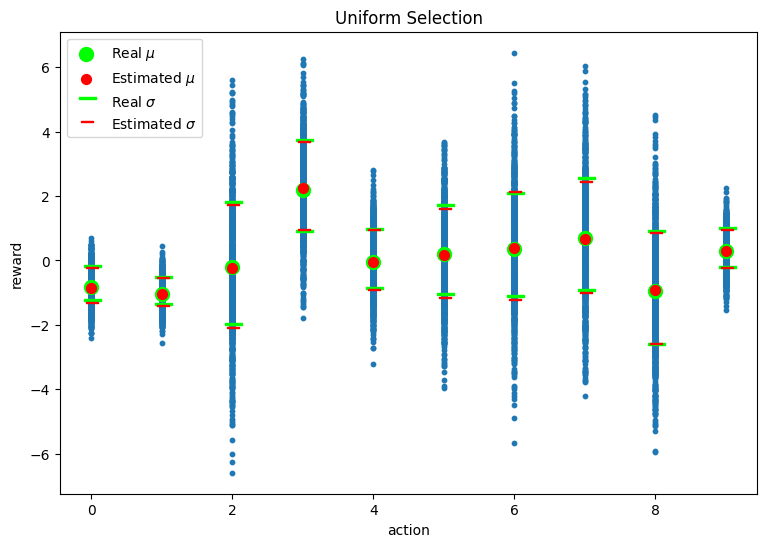

In [33]:
k_armed_bandit = KArmedBandit(10)
results = k_armed_bandit.uniformSelection(selections_per_arm=1000)
k_armed_bandit.draw(*results, "Uniform Selection")


|Variable|Name|Meaning|
|---|---|---|
|$t$|time step||
|$A_t$|Action|the action selected on time step t|
|$R_t$|Reward|the reward obtained after take action t|
|$q_*(a)$|Value|expected reward of action a|
|$Q_t(a)$|Value|the estimated value of action a at time step t|

$$q_*(a)=E[R_t|A_t=a]$$

- Definations:
  - Goal: we want $Q_t(a)$ to approach $q_*(a)$
  - Greedy action: the action whose estimated value is the greatest at any time step
  - Exploiting: taking greedy actions, maximize expected reward on one step
  - Exploring: taking nongreedy actions, produce greater total reward in the long run

# Action-value Methods

sample average method:
$$Q_t(a)=\frac{\sum_{i=1}^{t-1} R_i \cdot Bool(A_i=a)}{\sum_{i=1}^{t-1} Bool(A_i=a)} = \frac{SumPastReward(a)}{CountPast(a)}=AvgPastReward(a)$$

Greedy action selection:
$$A_t=\underset{a}{argmax}(Q_t(a))$$

Value updating
|Inferencing|Meaning|
|---|---|
|$Q_{n+1}=\frac{1}{n} \sum_{i=1}^n R_i$|The value for the next time step is the mean of all past rewards|
|$=\frac{1}{n}(R_n+ \sum_{i=1}^{n-1} R_i)$|The sum of all past rewards is equal to the latest reward plus all past rewards|
|$=\frac{1}{n}(R_n+ (n-1) \cdot \frac{1}{n-1} \sum_{i=1}^{n-1} R_i)$||
|$=\frac{1}{n}(R_n+ (n-1) \cdot Q_n)$|We split out the term $Q_n$, the old value, note that $nQ_n$ is the sum of all past reward, but we only take $n-1$ past rewards, and replace this part with $R_n$|
|$=\frac{1}{n}(R_n + nQ_n - Q_n)$|See, we kind of replace 1/n of the past reward by a new reward|
|$=Q_n + \frac{1}{n}(R_n-Q_n)$|New value is the older value plus a redisual term, $R_n-Q_n$ can be seen as the error, the influence of this error is 1/n|

比如，我们有数组$[R_1=1, R_2=2, R_3=3]$，那么平均值$Q_4=2$，现在有$R_4=4$，想要获得新的平均值$Q_5$，假设我们只知道$R_4=4$，那么我们知道旧的数组和为$3*Q_4=3*2=6$，我们要想更新，就得知道新的和，然后除以新数量，新数组和为$3*Q_4 + R_4 = 6 + 4 = 10$，那么新的平均值为$Q_5 = 10 / 4 = 2.5$，总结一下，想要获得新平均值，就是$Q_5 = \frac{1}{4} (3 * Q_4 + R_4) = \frac{1}{4} ((4-1) * Q_4 + R_4) = \frac{1}{4} (4 * Q_4 - Q_4 + R_4) = Q_4 + \frac{1}{4} (R_4 - Q_4)$，通项为 $Q_{n+1} = Q_n + \frac{1}{n}(R_n-Q_n)$。

需要注意的是，我们先拥有$Q_n$，然后根据$Q_n$选择$A_n$，然后得到$A_n$的反馈$R_n$，但$Q_n$是取决于$\{R_1, R_2, ..., R_{n-1}\}$的，$Q_n$与$R_n$无关，这就是为什么上述公式中同时涉及了n+1，n和n-1


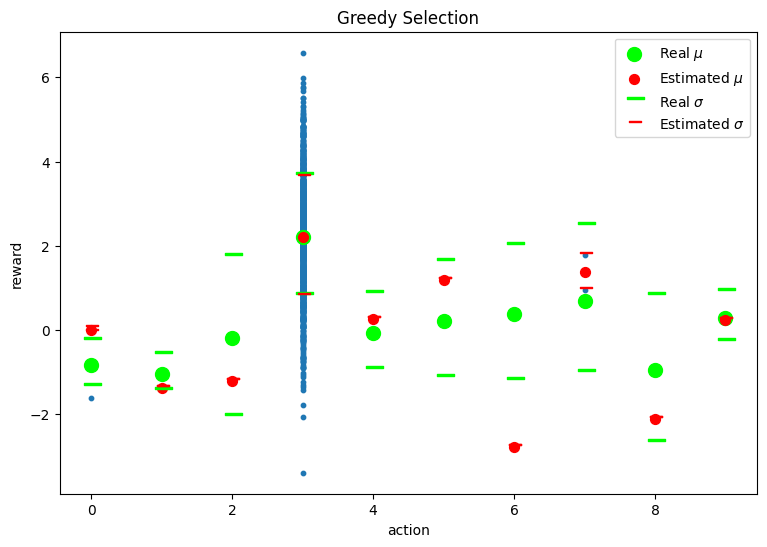

In [34]:
""" Now we can have greedy selection, note that in RL, things happend in order, in time steps, every time we do one action, and get one reward, then do one update """
results = k_armed_bandit.greedySelection(select_times=1000)
k_armed_bandit.draw(*results, "Greedy Selection")

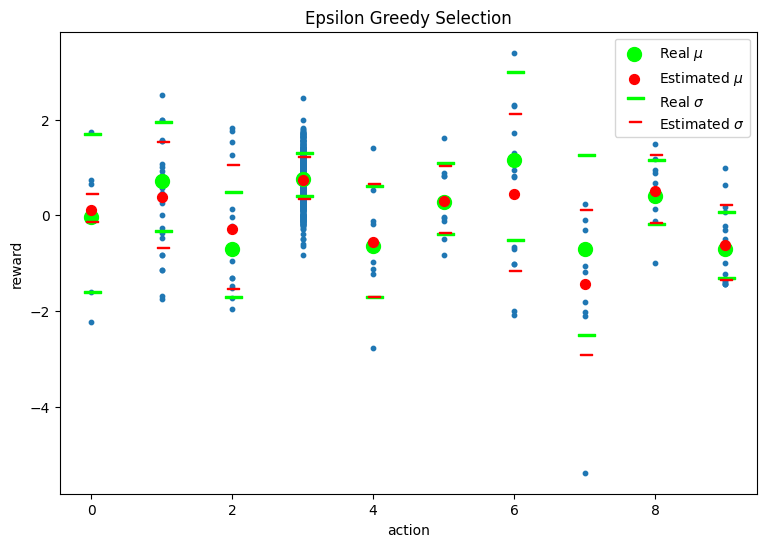

In [62]:
""" Now we can have epsilon greedy selectionne action """
k_armed_bandit = KArmedBandit(10)
results = k_armed_bandit.epsilonGreedySelection(select_times=1000, epsilon=0.1)
k_armed_bandit.draw(*results, "Epsilon Greedy Selection")